# PROCESO DE LIMPIEZA Y PRESENTACIÓN DE LOS DATOS

## Datos de Polución del Aire (SINCA)

La base de datos utilizada proviene del Sistema de Información Nacional de Calidad del Aire (SINCA) del Ministerio del Medio Ambiente de Chile, y contiene registros horarios de material particulado fino (PM₂.₅) de distintas estaciones ubicadas en la Región Metropolitana de Santiago. Se incluyen registros para el período 2017–2019, provenientes de diez comunas: Cerro Navia, Pudahuel, Quilicura, El Bosque, Cerrillos, Independencia, Las Condes, La Florida, Puente Alto y Parque O’Higgins. (https://sinca.mma.gob.cl/index.php/region/index/id/M)

Cada archivo .csv corresponde por cada estación de monitoreo de calidad del aire según su comuna desde el 2017 al 2019 en las comunas ya mencionadas. Contienen columnas como:

FECHA (YYMMDD) → fecha del registro en formato numérico (ej. 170101 para 1 de enero de 2017)

HORA (HHMM) → hora del registro

Registros validados → mediciones de PM₂.₅ validadas

Registros preliminares → mediciones de PM₂.₅ aún sin validar

Registros no validados → mediciones descartadas o sin revisión

Unnamed: 5 → columna vacía generada por el CSV

Los archivos fueron combinados en un solo DataFrame llamado df_contaminacion, agregando una columna estacion que indica la comuna de origen, y se generó una columna unificada PM25 que prioriza los registros validados y, cuando estos no existen, utiliza los preliminares. La decisión de unificar los registros validados y preliminares en PM25 permite aprovechar todos los datos disponibles sin perder calidad.

In [17]:
import pandas as pd
import os
import datetime as dt
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import zipfile
import seaborn as sns
from bs4 import BeautifulSoup

Lectura de datos del SINCA

In [18]:
ruta_sinca = os.path.join('data', 'Estaciones17-19')

# Diccionario de DataFrames
dfs_sinca = {}

for f in os.listdir(ruta_sinca):
    if f.endswith(".csv"):
        nombre = f.replace(".csv", "")  
        df = pd.read_csv(os.path.join(ruta_sinca, f), sep=';', decimal=',')
        dfs_sinca[nombre] = df

# Ejemplo de acceso
# dfs_sinca.keys()

# creamos columna con el nombre de cada estación
for nombre, df in dfs_sinca.items():
    df["Estacion"] = nombre.split("17-19")[0]
# dfs_sinca["Cerronavia17-19"].head()

# concatenar todos los DataFrames en uno solo ahora que ya sabemos a qué comuna corresponde cada medición
df_contaminacion = pd.concat(dfs_sinca.values(), ignore_index=True)
df_contaminacion.head()

,FECHA (YYMMDD),HORA (HHMM),Registros validados,Registros preliminares,Registros no validados,Unnamed: 5,Estacion
0,170101,0,21.5417,NaN,NaN,NaN,Quilicura
1,170102,0,31.2500,NaN,NaN,NaN,Quilicura
2,170103,0,52.6667,NaN,NaN,NaN,Quilicura
3,170104,0,31.2083,NaN,NaN,NaN,Quilicura
4,170105,0,16.5417,NaN,NaN,NaN,Quilicura


Sabemos que "Parque O'Higgins" es parte de la comuna de Santiago.

In [19]:
df_contaminacion['Estacion'].unique()

array(['Quilicura', 'Elbosque', 'ParqueOHiggins', 'Independencia',
       'Puentealto', 'Pudahuel', 'Talagante', 'Lascondes', 'Laflorida',
       'Cerronavia'], dtype=object)

In [20]:
# cambiar los nombres de las estaciones a nombres más amigables
nombre_estaciones = {
    'Cerronavia':'Cerro Navia', 'Elbosque': 'El Bosque', 'Independencia': 'Independencia', 'Laflorida':'La Florida',
    'Lascondes':'Las Condes', 'ParqueOHiggins':'Santiago', 'Pudahuel':'Pudahuel', 'Puentealto':'Puente Alto',
    'Quilicura':'Quilicura', 'Talagante':'Talagante'}

df_contaminacion['Estacion'] = df_contaminacion['Estacion'].map(nombre_estaciones)

# renombrar columna FECHA (YYMMDD) a FECHA y HORA (HHMM) a HORA
df_contaminacion = df_contaminacion.rename(columns={"FECHA (YYMMDD)": "FECHA", "HORA (HHMM)": "HORA"})

#Tranformamos fechas a datetime
df_contaminacion["FECHA"] = pd.to_datetime(df_contaminacion["FECHA"], format="%y%m%d", errors="coerce")

#Creamos una columna llamada PM25 con los valores de PM25 reemplazando aquellos registros que no tienen registros validados por registros preliminares
df_contaminacion["PM25"] = df_contaminacion["Registros validados"].fillna(df_contaminacion["Registros preliminares"])

# Eliminamo la columna Registros no validados y Unnamed: 5
df_contaminacion = df_contaminacion.drop(columns=["Registros no validados", "Unnamed: 5"], errors="ignore")

## Reportes de Salud MINSAL
- link: [Reportes Rem](https://reportesrem.minsal.cl/)

Los archivos a leer son con extensión `xls` con formato `html` escondido. La secuencia para solicitar los archivos y descargarlos de su fuente original es la siguiente:

#### Parámetros de los filtros:
- Serie -> **SERIE A**
- Rem -> **REMA04. CONSULTAS Y OTRAS ATENCIONES**
- Sección -> **SECCIÓN A: CONSULTAS MÉDICAS**
- Degregación -> **REGIONES**
- Regiones -> **METROPOLITANA DE SANTIAGO**
- Periodo -> **{año}**
- Mes Inicio -> **{mes}**
- Mes Final -> **{mes}**

En este caso se descargaron mes a mes.

In [21]:
rutaREM17 = os.path.join('data', 'REM', 'df_REM_2017.csv')
rutaREM18 = os.path.join('data', 'REM', 'df_REM_2018.csv')
rutaREM19 = os.path.join('data', 'REM', 'df_REM_2019.csv')

df_REM17 = pd.read_csv(rutaREM17)
df_REM18 = pd.read_csv(rutaREM18)
df_REM19 = pd.read_csv(rutaREM19)





Limpieza de los datos de REM:

In [22]:
# LIMPIAMOS LA COLUMNA n_pacientes CONVIERTIENDOLA A TIPO INT64

df_REM17['n_pacientes'] = df_REM17['n_pacientes'].astype('int64')


df_REM18['n_pacientes'] = df_REM18['n_pacientes'].astype('int64')


df_REM19['n_pacientes'] = df_REM19['n_pacientes'].astype('int64')

# ESTANDARIZAMOS LOS MESES
df_REM17['Mes'] = df_REM17['Mes'].str.capitalize()
df_REM18['Mes'] = df_REM18['Mes'].str.capitalize()
df_REM19['Mes'] = df_REM19['Mes'].str.capitalize()

# CREAMOS COLUMNA NUM_MES (FACILITA AL MOMENTO DE GRAFICAR)
mapeo_meses = {
    'Enero': 1, 'Febrero': 2, 'Marzo': 3, 'Abril': 4,
    'Mayo': 5, 'Junio': 6, 'Julio': 7, 'Agosto': 8,
    'Septiembre': 9, 'Octubre': 10, 'Noviembre': 11, 'Diciembre': 12
}

df_REM17['Num_mes'] = df_REM17['Mes'].map(mapeo_meses)
df_REM18['Num_mes'] = df_REM18['Mes'].map(mapeo_meses)
df_REM19['Num_mes'] = df_REM19['Mes'].map(mapeo_meses)

Veremos si se limpiaron bien las los tipos de consulta en los dataframes:

In [23]:
df_REM17['Consulta_por'].unique()

array(['IRA ALTA', 'SINDROME BRONQUIAL OBSTRUCTIVO', 'NEUMONÍA', 'ASMA',
       'ENFERMEDAD PULMONAR OBSTRUCTIVA CRÓNICA', 'OTRAS RESPIRATORIAS'],
      dtype=object)

In [24]:
df_REM18['Consulta_por'].unique()

array(['IRA ALTA', 'SINDROME BRONQUIAL OBSTRUCTIVO', 'NEUMONÍA', 'ASMA',
       'ENFERMEDAD PULMONAR OBSTRUCTIVA CRÓNICA', 'OTRAS RESPIRATORIAS',
       'CARDIOVASCULAR'], dtype=object)

In [25]:
df_REM19['Consulta_por'].unique()

array(['IRA ALTA', 'SINDROME BRONQUIAL OBSTRUCTIVO', 'NEUMONÍA', 'ASMA',
       'ENFERMEDAD PULMONAR OBSTRUCTIVA CRÓNICA', 'OTRAS RESPIRATORIAS',
       'CARDIOVASCULAR'], dtype=object)

Observamos que la consulta de tipo "CARDIOVASCULAR" no corresponde a una enfermedad respiratoria, por lo cual no corresponde que esté presente en el análisis. Lo eliminamos.

In [26]:
df_REM18 = df_REM18[df_REM18['Consulta_por'] != 'CARDIOVASCULAR']
df_REM19 = df_REM19[df_REM19['Consulta_por'] != 'CARDIOVASCULAR']

In [27]:
df_REM18['Consulta_por'].unique()

array(['IRA ALTA', 'SINDROME BRONQUIAL OBSTRUCTIVO', 'NEUMONÍA', 'ASMA',
       'ENFERMEDAD PULMONAR OBSTRUCTIVA CRÓNICA', 'OTRAS RESPIRATORIAS'],
      dtype=object)

In [28]:
df_REM19['Consulta_por'].unique()

array(['IRA ALTA', 'SINDROME BRONQUIAL OBSTRUCTIVO', 'NEUMONÍA', 'ASMA',
       'ENFERMEDAD PULMONAR OBSTRUCTIVA CRÓNICA', 'OTRAS RESPIRATORIAS'],
      dtype=object)

In [29]:
df_REM17['Consulta_por'] = df_REM17['Consulta_por'].astype('category')
df_REM18['Consulta_por'] = df_REM18['Consulta_por'].astype('category')
df_REM19['Consulta_por'] = df_REM19['Consulta_por'].astype('category')

Notar que el df, no tiene filas nulas.

In [30]:
df_REM17[df_REM17.isna().all(axis=1)]

,Consulta_por,n_pacientes,Comuna,Mes,Año,Num_mes


El data frame, tampoco tiene datos duplicados.

In [31]:
dups2017 = df_REM17.duplicated(keep=False)
dups2017 = df_REM17[dups2017]

dups2017

,Consulta_por,n_pacientes,Comuna,Mes,Año,Num_mes


## Mapa de la Región Metropolitana

Mapa vectorizado de todas las comunas de chile:

https://www.bcn.cl/siit/mapas_vectoriales

/var/folders/s2/1qf0t93x30974dty2q8hqn8c0000gn/T/ipykernel_23930/4222327275.py:24: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


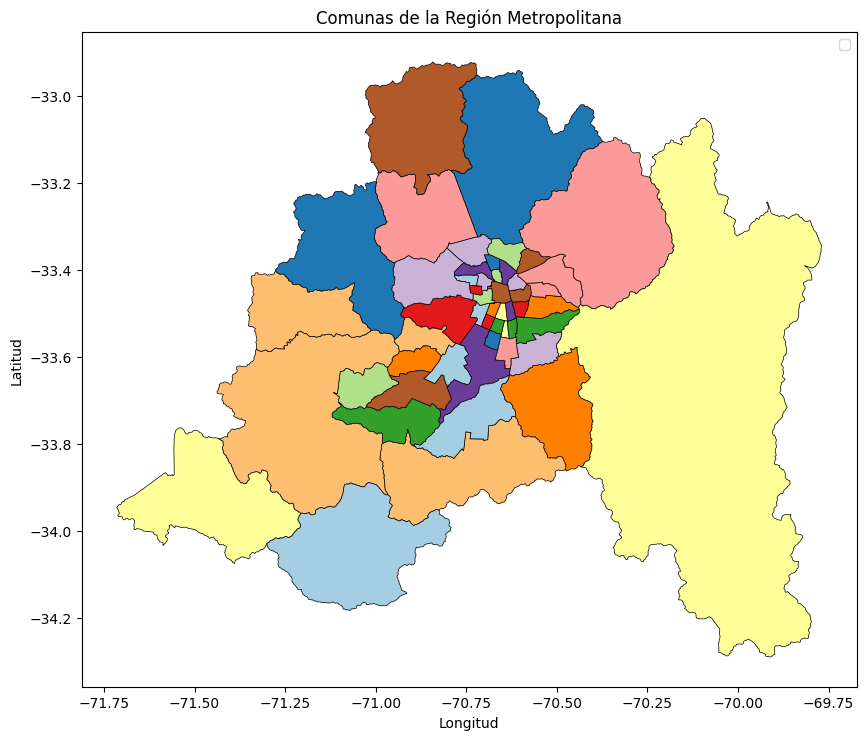

In [32]:
zipComunas = zipfile.ZipFile('data/Comunas/Comunas.zip', 'r')
with zipComunas as zip_coms:
    zip_coms.extractall(path='data/Comunas/')

# Para no tener problemas con computadores mac usamos join

nombre_archivo = 'comunas.shp'
ruta = os.path.join('data', 'Comunas', nombre_archivo)
comunas = gpd.read_file(ruta, use_arrow=True)

# reseteamos el crs a 4326
comunas['geometry'] = comunas['geometry'].to_crs(epsg=4326)

# dejamos solo las comunas de la RM
comunas = comunas[comunas['Region'] == 'Región Metropolitana de Santiago'].copy().reset_index(drop=True)

fig, ax = plt.subplots(figsize=(10, 10))
comunas.plot(column='Comuna', ax=ax, cmap='Paired', legend=True, linewidth=0.5, edgecolor='black')

ax.set_title("Comunas de la Región Metropolitana")
# titulo de los ejes
ax.set_xlabel("Longitud")
ax.set_ylabel("Latitud")
ax.legend()
plt.show()

Vemos que éstas son las comunas que presentan medidores de contaminación aerea:

/var/folders/s2/1qf0t93x30974dty2q8hqn8c0000gn/T/ipykernel_23930/2939393531.py:14: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()
/var/folders/s2/1qf0t93x30974dty2q8hqn8c0000gn/T/ipykernel_23930/2939393531.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


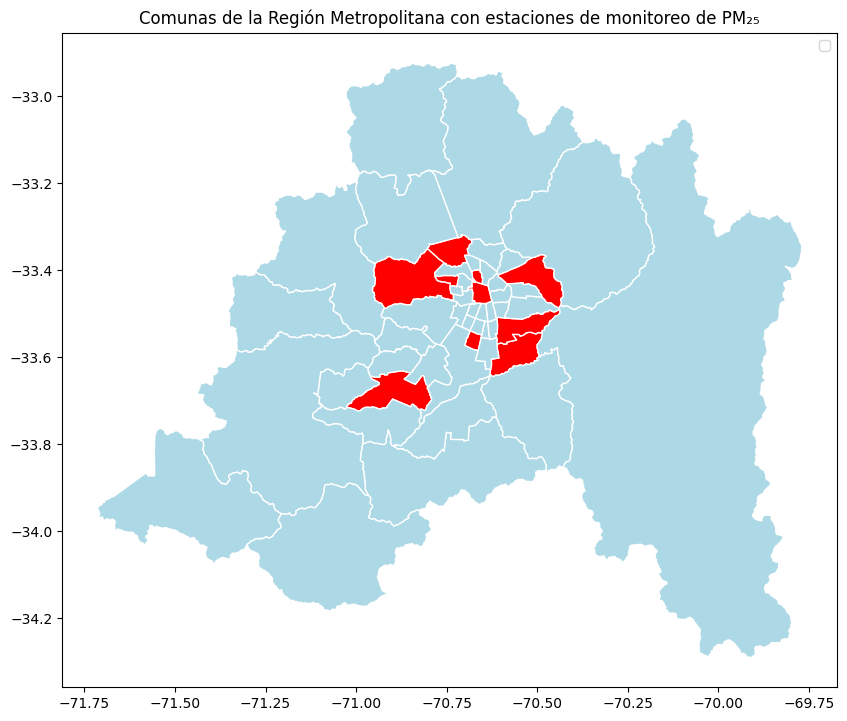

In [33]:
# Mostramos todas las comunas, distinguimos las que tienen estaciones de monitoreo de PM25 con rojo de las que no con celeste
medidores = list(df_contaminacion['Estacion'].unique())

fig, ax = plt.subplots(figsize=(10, 10))
comunas['Tiene_medidor'] = comunas['Comuna'].map(lambda x: x in medidores)

dentro = comunas[comunas['Tiene_medidor'] == True]
fuera_lista = comunas[comunas['Tiene_medidor'] == False]

dentro.plot(ax=ax, color='red', label='Con medidores', edgecolor='white')
fuera_lista.plot(ax=ax, color='lightblue', label='Sin medidores', edgecolor='white')

ax.set_title("Comunas de la Región Metropolitana con estaciones de monitoreo de PM₂₅")
ax.legend()
plt.show()

# ANALISIS NUMÉRICO

## Analisis numérico de comunas con (df_contaminacion)

In [34]:
df_contaminacion.head()

,FECHA,HORA,Registros validados,Registros preliminares,Estacion,PM25
0,2017-01-01,0,21.5417,NaN,Quilicura,21.5417
1,2017-01-02,0,31.2500,NaN,Quilicura,31.2500
2,2017-01-03,0,52.6667,NaN,Quilicura,52.6667
3,2017-01-04,0,31.2083,NaN,Quilicura,31.2083
4,2017-01-05,0,16.5417,NaN,Quilicura,16.5417


In [35]:
# Conteo total de nulos (sin registros validados ni preliminares)
nulos_total = df_contaminacion["PM25"].isna().sum()
total_registros = len(df_contaminacion)
porcentaje_nulos = (nulos_total / total_registros) * 100

print(f"Total de registros: {total_registros}")
print(f"Valores nulos en PM25: {nulos_total} ({porcentaje_nulos:.2f}%)")

Total de registros: 10940
Valores nulos en PM25: 582 (5.32%)


In [36]:
nulos_por_estacion = (
    df_contaminacion.groupby("Estacion")["PM25"]
    .apply(lambda x: x.isna().sum())
    .reset_index(name="nulos")
)

# Agregar porcentaje por estación
nulos_por_estacion["porcentaje"] = (
    nulos_por_estacion["nulos"] /
    df_contaminacion["Estacion"].value_counts().sort_index().values
) * 100

print(nulos_por_estacion)

        Estacion  nulos  porcentaje
0    Cerro Navia     45    4.113346
1      El Bosque     55    5.027422
2  Independencia     42    3.839122
3     La Florida     75    6.855576
4     Las Condes     56    5.118830
5       Pudahuel     52    4.753199
6    Puente Alto     47    4.296161
7      Quilicura     68    6.215722
8       Santiago     38    3.473492
9      Talagante    104    9.506399


Del total de 10.940 registros disponibles, se identificaron 582 valores faltantes en la variable PM₂.₅, equivalente al 5.32 % del conjunto de datos.
Estos casos corresponden a horas en las cuales las estaciones no registraron valores ni validados ni preliminares, posiblemente por mantenimiento o fallas técnicas.
Dado que la proporción de datos faltantes es moderada, se optó por eliminarlos del análisis.

In [37]:
df_contaminacion = df_contaminacion.dropna(subset=["PM25"])

In [38]:
# Promedio mensual (para graficar tendencias)
df_contaminacion.groupby([df_contaminacion["FECHA"].dt.month, "Estacion"])["PM25"].mean().unstack()

Estacion,Cerro Navia,El Bosque,Independencia,La Florida,Las Condes,Pudahuel,Puente Alto,Quilicura,Santiago,Talagante
FECHA,,,,,,,,,,
1,21.566306,23.411162,25.377509,22.292601,24.040539,19.747309,20.462530,22.002691,22.914684,15.113699
2,17.850607,20.287103,19.854935,16.839518,18.422698,16.614130,15.355764,16.843877,18.481648,11.639735
3,18.270054,20.264554,17.764832,17.236677,17.852412,16.465019,15.682777,16.906531,18.873933,12.610276
4,28.759261,29.800150,25.761008,26.450460,22.919354,25.656631,23.126287,24.160606,24.876813,19.269707
5,43.387097,41.741935,33.795699,33.641304,24.434783,39.704545,27.827957,33.560440,33.731183,32.159091
6,59.625000,54.244444,42.977528,40.855556,24.306818,54.920455,32.988764,44.494253,44.200000,42.308642
7,58.086022,55.413043,46.163043,43.865169,29.134831,53.380435,36.988889,44.892473,46.086022,43.634409
8,41.387097,41.184783,35.195652,34.380435,25.247312,37.163043,29.173913,33.630435,35.021505,30.086022
9,25.879518,25.775000,23.975904,23.468354,19.615385,23.294872,20.101124,21.518519,23.392857,17.975309


In [39]:
# Conteo de datos por año
df_contaminacion["FECHA"].dt.year.value_counts()

FECHA
2019    3500
2017    3440
2018    3418
Name: count, dtype: int64

#### Estadísticas descriptivas

El análisis inicial de la variable PM25 evidencia diferencias espaciales y estacionales significativas:

Las comunas del sector poniente (Cerro Navia, Pudahuel) presentan concentraciones más altas.

Las comunas del sector oriente (Las Condes, La Florida) presentan concentraciones más bajas.

Durante el invierno, los niveles de PM₂.₅ aumentan considerablemente, mientras que en verano disminuyen.

In [40]:
df_contaminacion.groupby("Estacion")["PM25"].describe()

,count,mean,std,min,25%,50%,75%,max
Estacion,,,,,,,,
Cerro Navia,1049.0,30.701520,21.394474,6.62500,15.000000,21.12500,41.0,136.0000
El Bosque,1039.0,30.717268,19.274661,5.00000,16.000000,23.70830,41.0,101.0000
Independencia,1052.0,26.979252,15.294207,5.00000,16.000000,22.00000,34.0,92.7084
La Florida,1019.0,25.671920,15.239289,4.70834,14.000000,21.00000,34.0,89.0416
Las Condes,1038.0,21.131355,10.364915,4.00000,14.000000,19.00000,26.0,92.0000
Pudahuel,1042.0,27.650708,20.052234,4.00000,13.000000,19.02085,37.0,134.0000
Puente Alto,1047.0,22.195295,12.674198,2.00000,13.000000,18.79170,28.0,70.7500
Quilicura,1026.0,25.403205,15.896353,3.00000,14.000000,20.00000,34.0,80.0000
Santiago,1056.0,26.349568,15.764594,4.00000,14.125025,21.00000,34.0,88.0000


In [41]:
df_contaminacion.groupby("Estacion")["PM25"].mean().sort_values(ascending=False)

Estacion
El Bosque        30.717268
Cerro Navia      30.701520
Pudahuel         27.650708
Independencia    26.979252
Santiago         26.349568
La Florida       25.671920
Quilicura        25.403205
Puente Alto      22.195295
Talagante        22.185104
Las Condes       21.131355
Name: PM25, dtype: float64

## Analisis numérico de comunas con (df_REM17, df_REM18 y df_REM19)

Promedio:

In [42]:
print(df_REM17['n_pacientes'].mean())
print(df_REM18['n_pacientes'].mean())
print(df_REM19['n_pacientes'].mean())

130.0403311965812
126.70833333333333
149.32291666666666


In [43]:
df_REM17.describe(include='all')

,Consulta_por,n_pacientes,Comuna,Mes,Año,Num_mes
count,3744,3744.000000,3744,3744,3744.0,3744.000000
unique,6,NaN,52,12,NaN,NaN
top,ASMA,NaN,Santiago,Enero,NaN,NaN
freq,624,NaN,72,312,NaN,NaN
mean,NaN,130.040331,NaN,NaN,2017.0,6.500000
std,NaN,195.096560,NaN,NaN,0.0,3.452514
min,NaN,0.000000,NaN,NaN,2017.0,1.000000
25%,NaN,11.000000,NaN,NaN,2017.0,3.750000
50%,NaN,44.000000,NaN,NaN,2017.0,6.500000
75%,NaN,159.250000,NaN,NaN,2017.0,9.250000


In [44]:
df_REM18.describe(include='all')

,Consulta_por,n_pacientes,Comuna,Mes,Año,Num_mes
count,3744,3744.000000,3744,3744,3744.0,3744.000000
unique,6,NaN,52,12,NaN,NaN
top,ASMA,NaN,Santiago,Enero,NaN,NaN
freq,624,NaN,72,312,NaN,NaN
mean,NaN,126.708333,NaN,NaN,2018.0,6.500000
std,NaN,188.204736,NaN,NaN,0.0,3.452514
min,NaN,0.000000,NaN,NaN,2018.0,1.000000
25%,NaN,11.000000,NaN,NaN,2018.0,3.750000
50%,NaN,45.000000,NaN,NaN,2018.0,6.500000
75%,NaN,158.000000,NaN,NaN,2018.0,9.250000


In [45]:
df_REM19.describe(include='all')

,Consulta_por,n_pacientes,Comuna,Mes,Año,Num_mes
count,3744,3744.000000,3744,3744,3744.0,3744.000000
unique,6,NaN,52,12,NaN,NaN
top,ASMA,NaN,Santiago,Enero,NaN,NaN
freq,624,NaN,72,312,NaN,NaN
mean,NaN,149.322917,NaN,NaN,2019.0,6.500000
std,NaN,212.024881,NaN,NaN,0.0,3.452514
min,NaN,0.000000,NaN,NaN,2019.0,1.000000
25%,NaN,12.000000,NaN,NaN,2019.0,3.750000
50%,NaN,58.000000,NaN,NaN,2019.0,6.500000
75%,NaN,186.000000,NaN,NaN,2019.0,9.250000


Promedio de pacientes por condicón de consulta por cada año

In [46]:
df_REM17.groupby('Consulta_por').agg({'n_pacientes':'mean'})

/var/folders/s2/1qf0t93x30974dty2q8hqn8c0000gn/T/ipykernel_23930/936231586.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_REM17.groupby('Consulta_por').agg({'n_pacientes':'mean'})


,n_pacientes
Consulta_por,
ASMA,52.019231
ENFERMEDAD PULMONAR OBSTRUCTIVA CRÓNICA,25.737179
IRA ALTA,258.820513
NEUMONÍA,78.546474
OTRAS RESPIRATORIAS,234.315705
SINDROME BRONQUIAL OBSTRUCTIVO,130.802885


In [47]:
df_REM18.groupby('Consulta_por').agg({'n_pacientes':'mean'})

/var/folders/s2/1qf0t93x30974dty2q8hqn8c0000gn/T/ipykernel_23930/1109401504.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_REM18.groupby('Consulta_por').agg({'n_pacientes':'mean'})


,n_pacientes
Consulta_por,
ASMA,51.051282
ENFERMEDAD PULMONAR OBSTRUCTIVA CRÓNICA,24.876603
IRA ALTA,266.903846
NEUMONÍA,70.769231
OTRAS RESPIRATORIAS,225.612179
SINDROME BRONQUIAL OBSTRUCTIVO,121.036859


In [48]:
df_REM19.groupby('Consulta_por').agg({'n_pacientes':'mean'})

/var/folders/s2/1qf0t93x30974dty2q8hqn8c0000gn/T/ipykernel_23930/3828265563.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_REM19.groupby('Consulta_por').agg({'n_pacientes':'mean'})


,n_pacientes
Consulta_por,
ASMA,87.854167
ENFERMEDAD PULMONAR OBSTRUCTIVA CRÓNICA,42.578526
IRA ALTA,239.352564
NEUMONÍA,106.750000
OTRAS RESPIRATORIAS,261.451923
SINDROME BRONQUIAL OBSTRUCTIVO,157.950321


Mes con menos enfermos por cada año:

In [49]:
df_REM17.groupby('Consulta_por').agg({'Mes':'min'})

/var/folders/s2/1qf0t93x30974dty2q8hqn8c0000gn/T/ipykernel_23930/1117728852.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_REM17.groupby('Consulta_por').agg({'Mes':'min'})


,Mes
Consulta_por,
ASMA,Abril
ENFERMEDAD PULMONAR OBSTRUCTIVA CRÓNICA,Abril
IRA ALTA,Abril
NEUMONÍA,Abril
OTRAS RESPIRATORIAS,Abril
SINDROME BRONQUIAL OBSTRUCTIVO,Abril


In [50]:
df_REM18.groupby('Consulta_por').agg({'Mes':'min'})

/var/folders/s2/1qf0t93x30974dty2q8hqn8c0000gn/T/ipykernel_23930/3328284695.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_REM18.groupby('Consulta_por').agg({'Mes':'min'})


,Mes
Consulta_por,
ASMA,Abril
ENFERMEDAD PULMONAR OBSTRUCTIVA CRÓNICA,Abril
IRA ALTA,Abril
NEUMONÍA,Abril
OTRAS RESPIRATORIAS,Abril
SINDROME BRONQUIAL OBSTRUCTIVO,Abril


In [51]:
df_REM19.groupby('Consulta_por').agg({'Mes':'min'})

/var/folders/s2/1qf0t93x30974dty2q8hqn8c0000gn/T/ipykernel_23930/1160611079.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_REM19.groupby('Consulta_por').agg({'Mes':'min'})


,Mes
Consulta_por,
ASMA,Abril
ENFERMEDAD PULMONAR OBSTRUCTIVA CRÓNICA,Abril
IRA ALTA,Abril
NEUMONÍA,Abril
OTRAS RESPIRATORIAS,Abril
SINDROME BRONQUIAL OBSTRUCTIVO,Abril


El mes con más consultas por año:

In [52]:
df_REM17.groupby('Consulta_por').agg({'Mes':'max'})

/var/folders/s2/1qf0t93x30974dty2q8hqn8c0000gn/T/ipykernel_23930/2770611120.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_REM17.groupby('Consulta_por').agg({'Mes':'max'})


,Mes
Consulta_por,
ASMA,Septiembre
ENFERMEDAD PULMONAR OBSTRUCTIVA CRÓNICA,Septiembre
IRA ALTA,Septiembre
NEUMONÍA,Septiembre
OTRAS RESPIRATORIAS,Septiembre
SINDROME BRONQUIAL OBSTRUCTIVO,Septiembre


In [53]:
df_REM18.groupby('Consulta_por').agg({'Mes':'max'})

/var/folders/s2/1qf0t93x30974dty2q8hqn8c0000gn/T/ipykernel_23930/172660187.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_REM18.groupby('Consulta_por').agg({'Mes':'max'})


,Mes
Consulta_por,
ASMA,Septiembre
ENFERMEDAD PULMONAR OBSTRUCTIVA CRÓNICA,Septiembre
IRA ALTA,Septiembre
NEUMONÍA,Septiembre
OTRAS RESPIRATORIAS,Septiembre
SINDROME BRONQUIAL OBSTRUCTIVO,Septiembre


In [54]:
df_REM19.groupby('Consulta_por').agg({'Mes':'max'})

/var/folders/s2/1qf0t93x30974dty2q8hqn8c0000gn/T/ipykernel_23930/3866783661.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_REM19.groupby('Consulta_por').agg({'Mes':'max'})


,Mes
Consulta_por,
ASMA,Septiembre
ENFERMEDAD PULMONAR OBSTRUCTIVA CRÓNICA,Septiembre
IRA ALTA,Septiembre
NEUMONÍA,Septiembre
OTRAS RESPIRATORIAS,Septiembre
SINDROME BRONQUIAL OBSTRUCTIVO,Septiembre


Promedio de paciente por comuna

In [55]:
df_REM17.groupby("Comuna")["n_pacientes"].mean().sort_values(ascending=False)

Comuna
Peñalolén              313.125000
La Florida             224.402778
La Pintana             218.763889
San Bernardo           218.680556
Santiago               207.736111
La Granja              201.875000
Maipú                  201.541667
Pudahuel               200.305556
Buin                   200.250000
Lampa                  199.527778
Cerro Navia            192.430556
Conchalí               190.875000
Puente Alto            184.208333
Lo Prado               183.986111
Recoleta               183.833333
Quilicura              180.444444
Paine                  178.152778
El Bosque              175.319444
Huechuraba             174.791667
Renca                  166.222222
Pedro Aguirre Cerda    164.236111
Independencia          163.930556
Quinta Normal          156.347222
Lo Espejo              150.180556
Colina                 144.722222
Melipilla              138.250000
Las Condes             132.319444
San Joaquín            128.819444
Estación Central       124.555556
Ñuñoa  

In [56]:
df_REM18.groupby("Comuna")["n_pacientes"].mean().sort_values(ascending=False)

Comuna
Peñalolén              341.541667
San Bernardo           250.875000
La Granja              221.708333
Buin                   203.861111
Pudahuel               201.305556
Cerro Navia            200.361111
Maipú                  200.138889
El Bosque              198.750000
La Pintana             195.763889
Quinta Normal          194.486111
La Florida             194.430556
Lampa                  192.097222
Lo Prado               189.375000
Recoleta               187.847222
Conchalí               182.208333
Paine                  179.930556
Puente Alto            167.986111
Santiago               166.402778
Huechuraba             165.263889
Lo Espejo              150.055556
Pedro Aguirre Cerda    149.708333
Renca                  149.472222
Quilicura              145.805556
Independencia          138.013889
Las Condes             126.777778
Melipilla              124.666667
Ñuñoa                  124.180556
San Joaquín            119.083333
Peñaflor               113.763889
San Mig

In [57]:
df_REM19.groupby("Comuna")["n_pacientes"].mean().sort_values(ascending=False)

Comuna
Maipu                  263.375000
Peñalolén              227.625000
Buin                   225.847222
La Florida             225.430556
Lo Espejo              222.138889
Puente Alto            214.083333
El Bosque              214.000000
La Granja              205.861111
La Pintana             202.263889
San Miguel             194.416667
Ñuñoa                  194.375000
Quilicura              189.291667
San Bernardo           181.916667
Cerro Navia            181.777778
Las Condes             181.250000
Conchalí               180.277778
Peñaflor               179.611111
Melipilla              174.041667
Pedro Aguirre Cerda    171.944444
Renca                  171.652778
Huechuraba             169.430556
San Joaquín            168.847222
Lo Barnechea           165.000000
Lampa                  163.527778
Quinta Normal          159.222222
Pudahuel               158.500000
Maria Pinto            154.111111
Colina                 152.666667
Paine                  150.388889
Indepen

# Analisis Visual:

La distribución PM₂₅ en diferentes formatos:

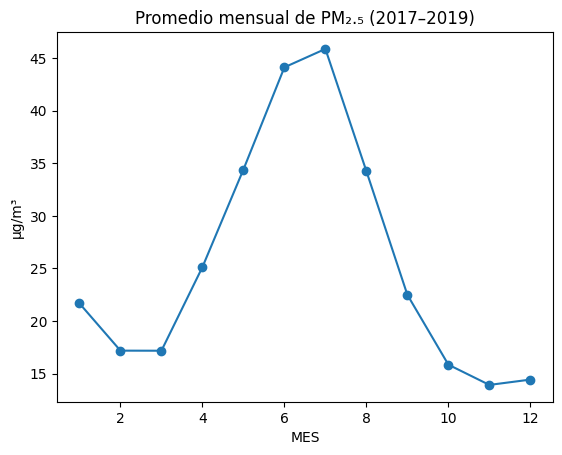

In [58]:
# Promedio mensual de PM2.5
df_contaminacion["MES"] = df_contaminacion["FECHA"].dt.month
df_contaminacion.groupby("MES")["PM25"].mean().plot(marker="o", title="Promedio mensual de PM₂.₅ (2017–2019)")
plt.ylabel("µg/m³")
plt.show()

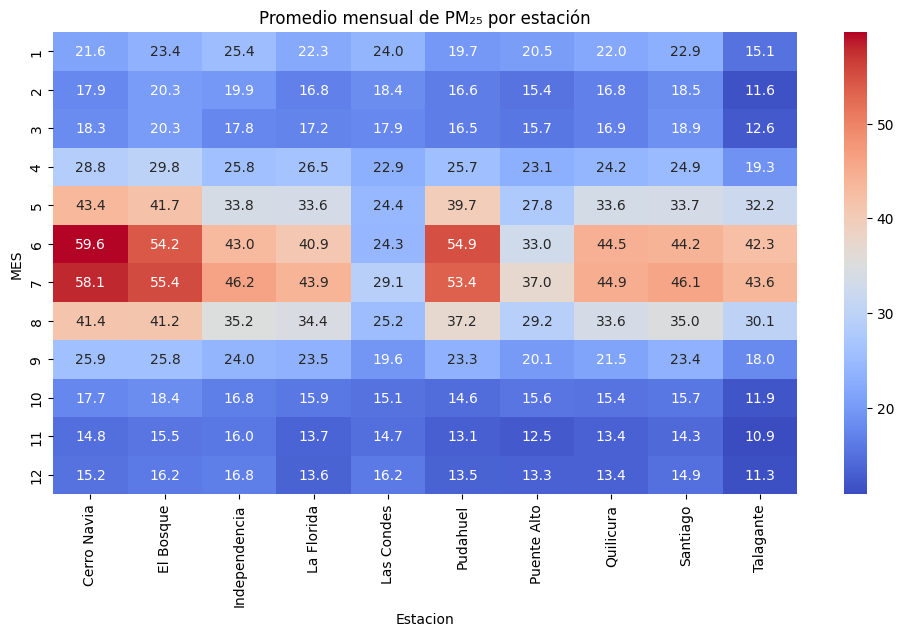

In [59]:
df_mes_estacion = df_contaminacion.groupby(["MES","Estacion"])["PM25"].mean().unstack()
plt.figure(figsize=(12,6))
sns.heatmap(df_mes_estacion, annot=True, fmt=".1f", cmap="coolwarm")
plt.title("Promedio mensual de PM₂₅ por estación")
plt.show()

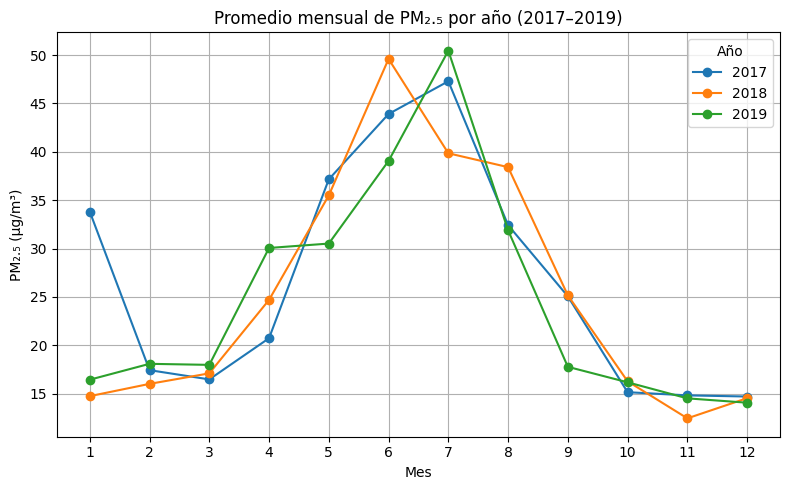

In [60]:
# Crear columnas de año y mes
df_contaminacion["AÑO"] = df_contaminacion["FECHA"].dt.year

# Agrupar por año y mes, y calcular el promedio de PM2.5
promedios = (
    df_contaminacion.groupby(["AÑO", "MES"])["PM25"]
    .mean()
    .reset_index()
)

# Crear la figura
plt.figure(figsize=(8,5))

# Graficar una línea por año
for año in sorted(df_contaminacion["AÑO"].unique()):
    data_año = promedios[promedios["AÑO"] == año]
    plt.plot(data_año["MES"], data_año["PM25"], marker="o", label=str(año))

# Personalizar
plt.title("Promedio mensual de PM₂.₅ por año (2017–2019)")
plt.xlabel("Mes")
plt.ylabel("PM₂.₅ (µg/m³)")
plt.xticks(range(1,13))
plt.legend(title="Año")
plt.grid(True)
plt.tight_layout()
plt.show()

## La distribución de pacientes por comuna en cada mes, en diferentes formatos:

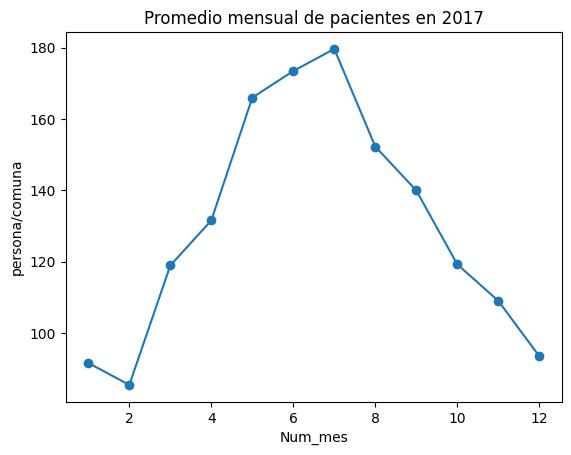

In [61]:
# Promedio mensual de pacientes por año
# clean_df_2017["MES"] = clean_df_2017["FECHA"].dt.month
df_REM17.groupby("Num_mes")["n_pacientes"].mean().plot(marker="o", title="Promedio mensual de pacientes en 2017")
plt.ylabel("persona/comuna")
plt.show()

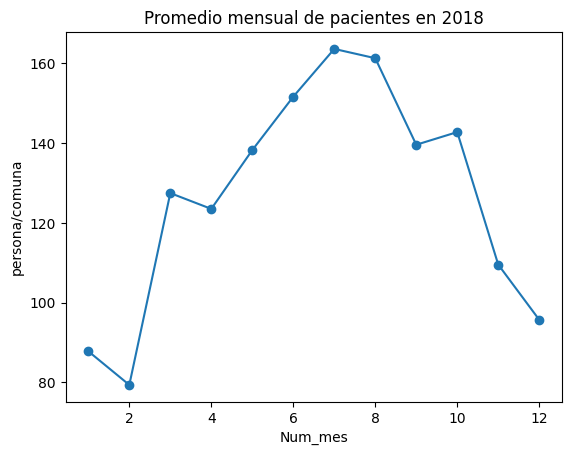

In [62]:
# Promedio mensual de pacientes por año
# clean_df_2017["MES"] = clean_df_2017["FECHA"].dt.month
df_REM18.groupby("Num_mes")["n_pacientes"].mean().plot(marker="o", title="Promedio mensual de pacientes en 2018")
plt.ylabel("persona/comuna")
plt.show()

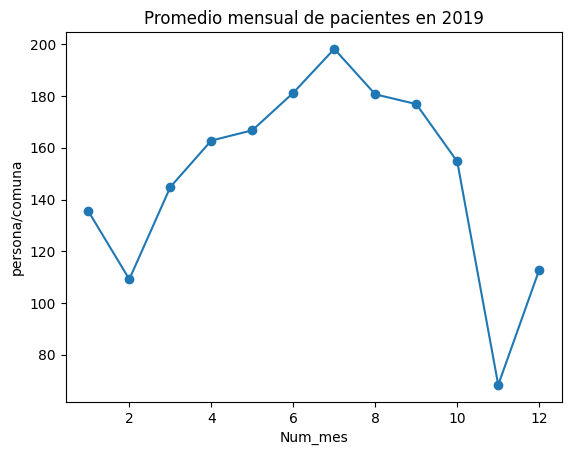

In [63]:
# Promedio mensual de pacientes por año
# clean_df_2017["MES"] = clean_df_2017["FECHA"].dt.month
df_REM19.groupby("Num_mes")["n_pacientes"].mean().plot(marker="o", title="Promedio mensual de pacientes en 2019")
plt.ylabel("persona/comuna")
plt.show()

Observamos que efectivamente el período en qué existen más pacientes de enfermedades respiratorias es en el periodo de Inveierno.

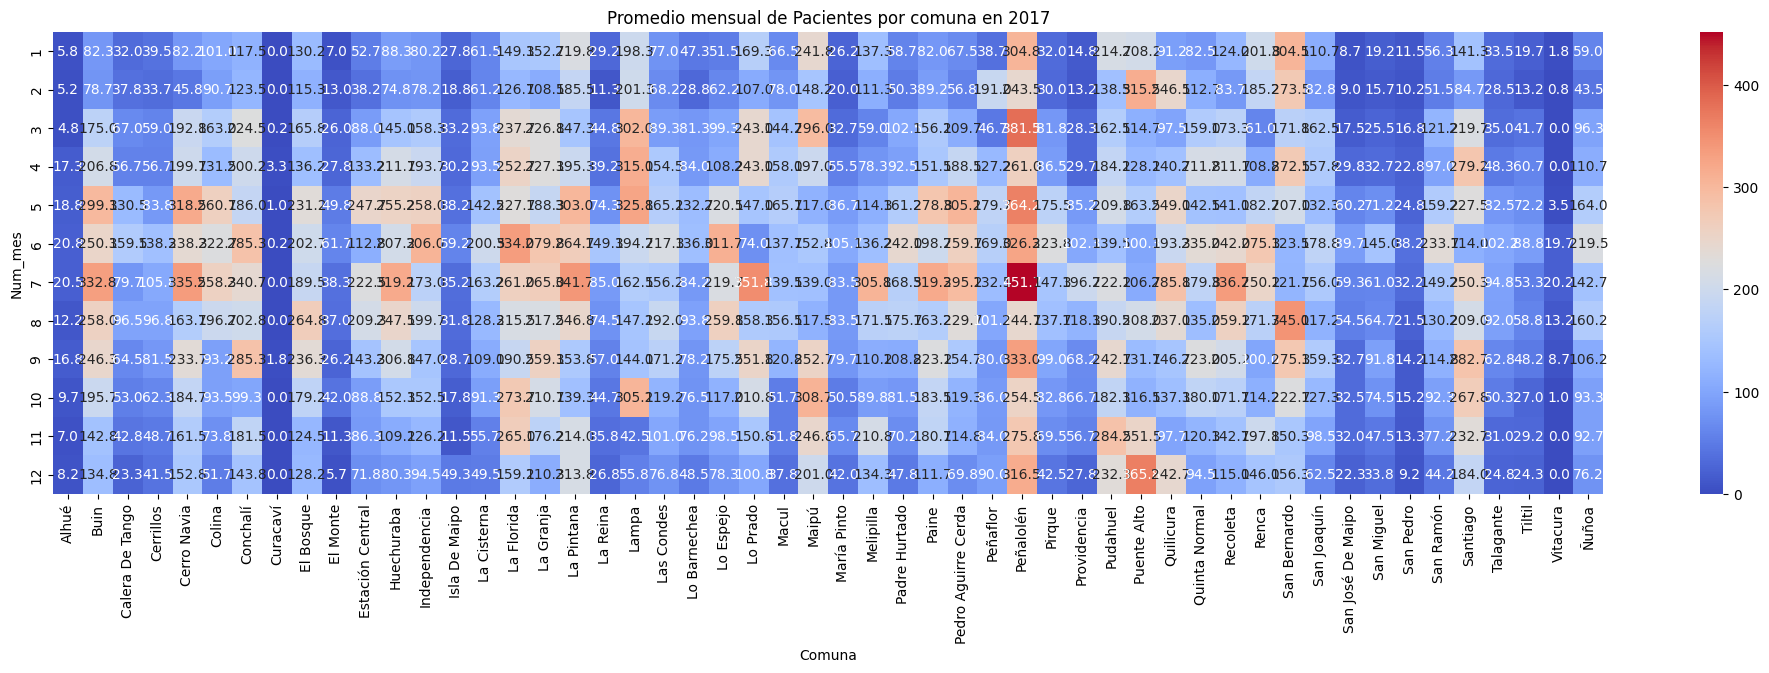

In [64]:
df_pacientes_comuna_2017 = df_REM17.groupby(["Num_mes", "Comuna"])["n_pacientes"].mean().unstack()
plt.figure(figsize=(25,6))
sns.heatmap(df_pacientes_comuna_2017, annot=True, fmt=".1f", cmap="coolwarm")
plt.title("Promedio mensual de Pacientes por comuna en 2017")
plt.show()

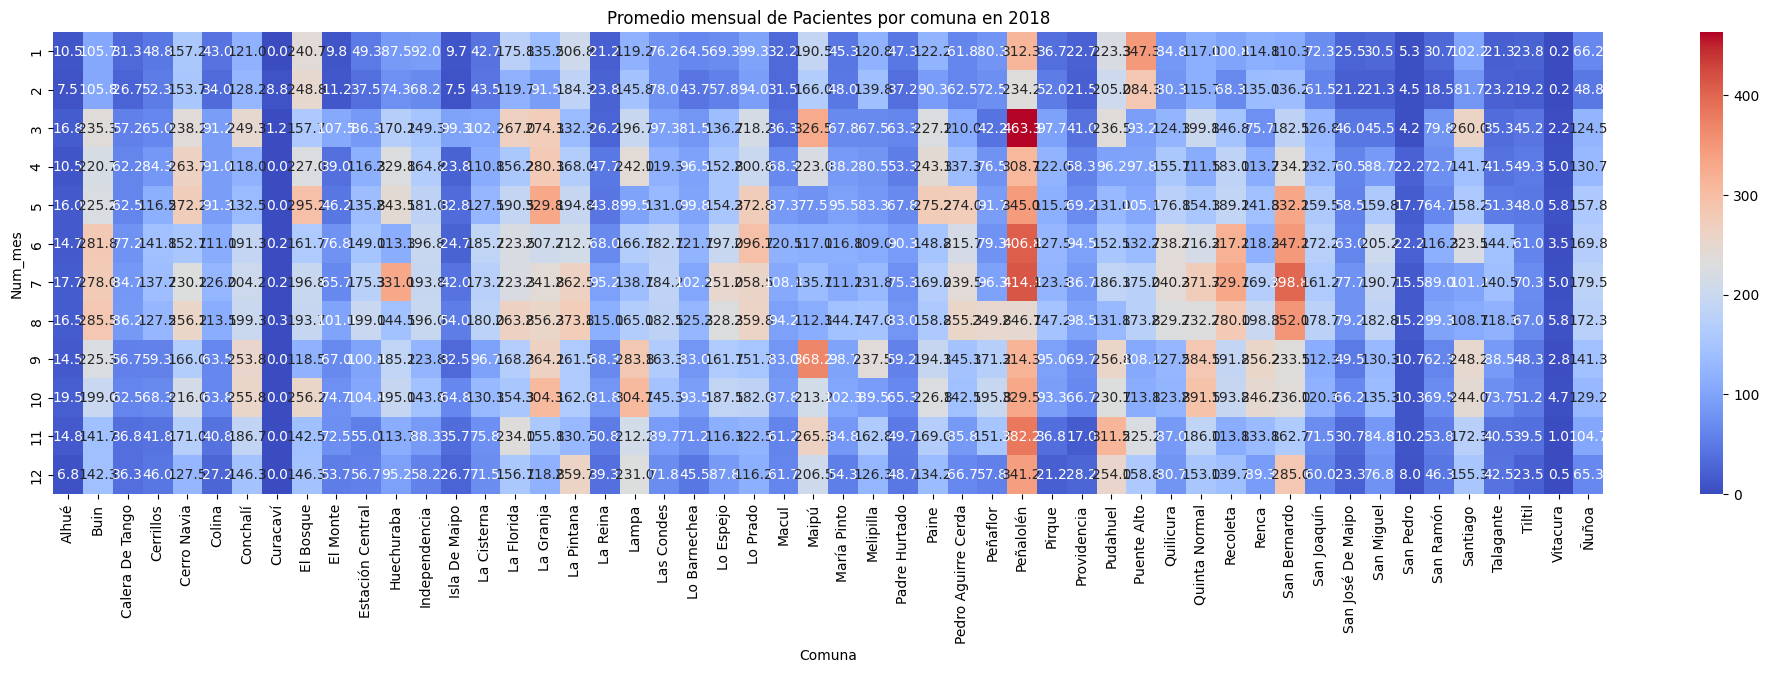

In [65]:
df_pacientes_comuna_2018 = df_REM18.groupby(["Num_mes", "Comuna"])["n_pacientes"].mean().unstack()
plt.figure(figsize=(25,6))
sns.heatmap(df_pacientes_comuna_2018, annot=True, fmt=".1f", cmap="coolwarm")
plt.title("Promedio mensual de Pacientes por comuna en 2018")
plt.show()

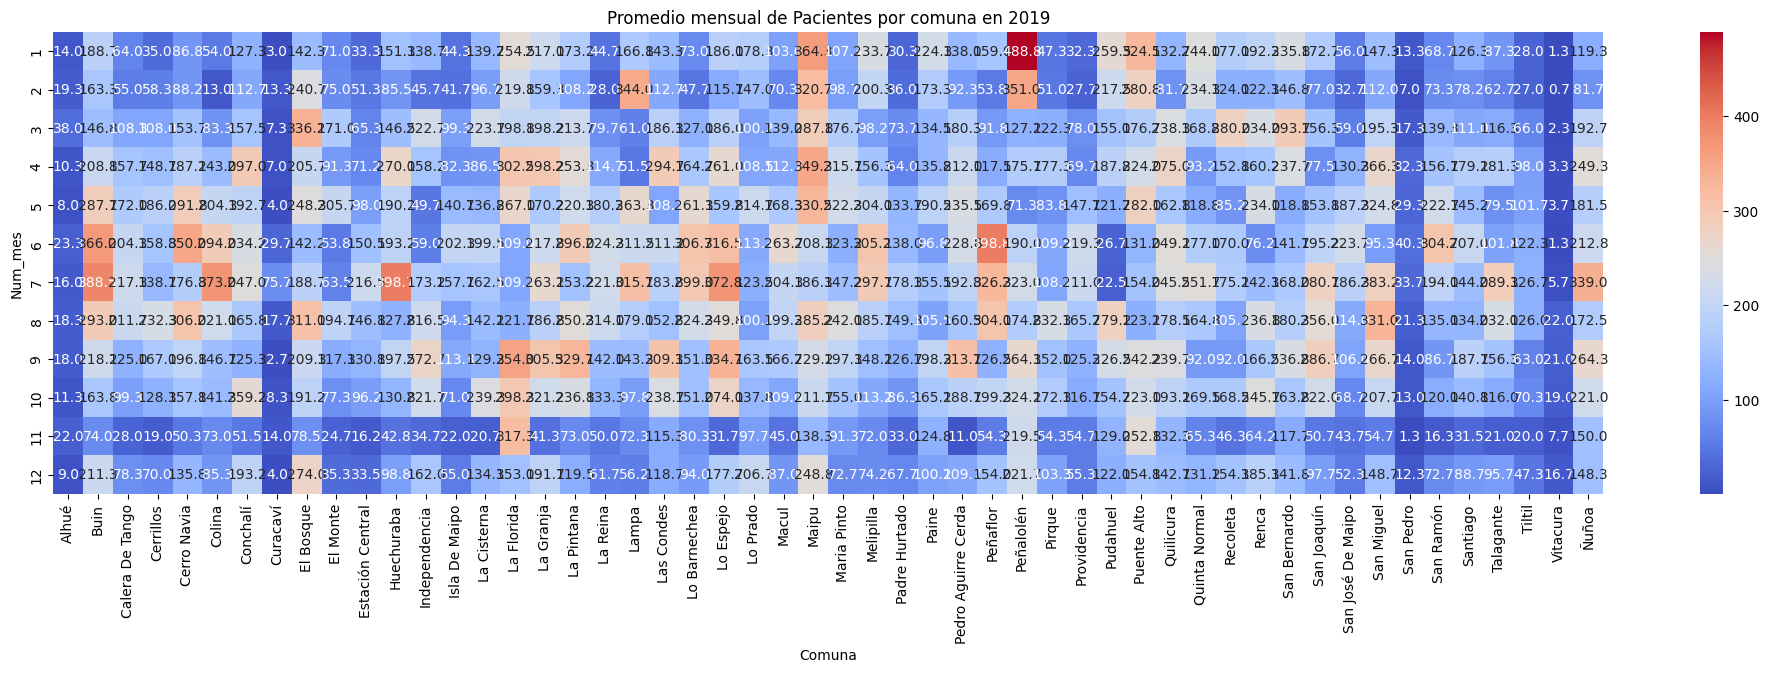

In [66]:
df_pacientes_comuna_2019 = df_REM19.groupby(["Num_mes", "Comuna"])["n_pacientes"].mean().unstack()
plt.figure(figsize=(25,6))
sns.heatmap(df_pacientes_comuna_2019, annot=True, fmt=".1f", cmap="coolwarm")
plt.title("Promedio mensual de Pacientes por comuna en 2019")
plt.show()

# RELACION DE DATOS

Primero graficaremos la cantidad de paciente por comuna por año v/s indice promedio de contaminación por comuna por año.

In [67]:
def plotear_anual(año, df_rem_total, df_contam_total, comunas_gdf):
    """
    Genera una figura con dos mapas comparativos (Pacientes vs PM2.5) para un año dado.
    """
    # Filtrar datos para el año específico
    df_rem_año = df_rem_total[df_rem_total['Año'] == año]
    df_contam_año = df_contam_total[df_contam_total['Año'] == año] # Asumo que df_contam_total tiene columna 'Año'

    # Preparar datos de Pacientes
    promedio_pacientes = df_rem_año.groupby('Comuna')['n_pacientes'].mean().reset_index()
    mapa_pacientes = comunas_gdf.merge(promedio_pacientes, on='Comuna', how='left')

    # Preparar datos de Contaminación ---
    # Asumimos que df_contam_total ya tiene la columna 'Comuna' (renombrada de 'Estacion')
    promedio_pm25 = df_contam_año.groupby('Comuna')['PM25'].mean().reset_index()
    mapa_pm25 = comunas_gdf.merge(promedio_pm25, on='Comuna', how='left')

    # Configuración y Ploteo Lado a Lado
    fig, axes = plt.subplots(1, 2, figsize=(24, 10), sharex=True, sharey=True)
    ax1, ax2 = axes # Desempaquetar los ejes

    # Mapa de Pacientes (Izquierda)
    mapa_pacientes.plot(
        column='n_pacientes',
        ax=ax1,
        cmap='RdBu_r', # color cmap inverso del PM2.5 para mejor contraste 
        legend=True,
        edgecolor='black',
        linewidth=0.5,
        missing_kwds={"color": "lightgrey", "label": "Sin Datos"}
    )
    ax1.set_title(f'Promedio de Pacientes por Comuna ({año})', fontsize=16)
    ax1.set_axis_off()

    # Mapa de PM2.5 (Derecha)
    mapa_pm25.plot(
        column='PM25',
        ax=ax2,
        cmap='RdBu_r',
        legend=True,
        edgecolor='black',
        linewidth=0.5,
        missing_kwds={"color": "lightgrey", "label": "Sin Datos"}
    )
    ax2.set_title(f'Promedio de PM2.5 por Comuna ({año})', fontsize=16)
    ax2.set_axis_off()

    plt.suptitle(f'Comparativa Anual: Pacientes vs. Polución - Año {año}', fontsize=18, y=1.02)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Ajusta el layout para que el supertítulo no se corte
    plt.show()

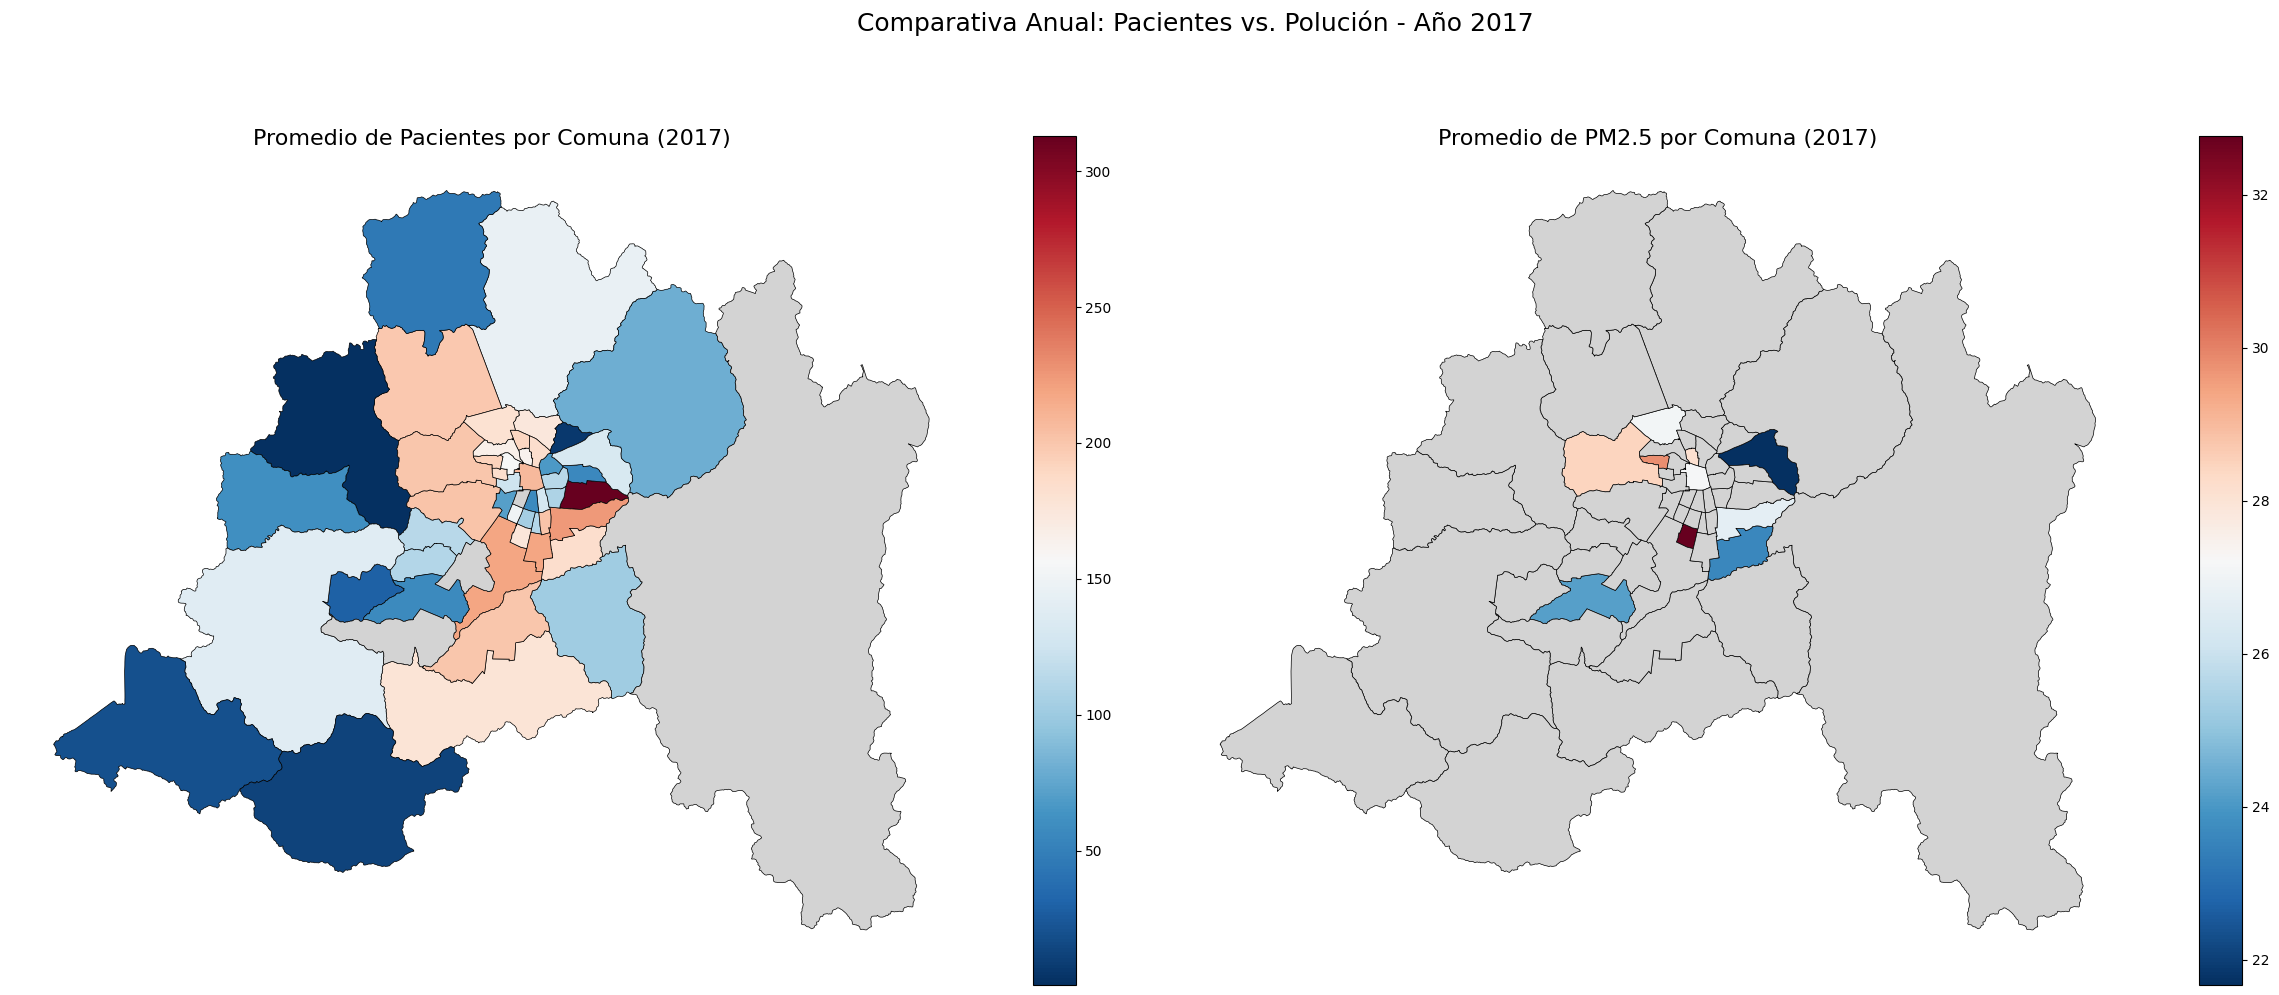

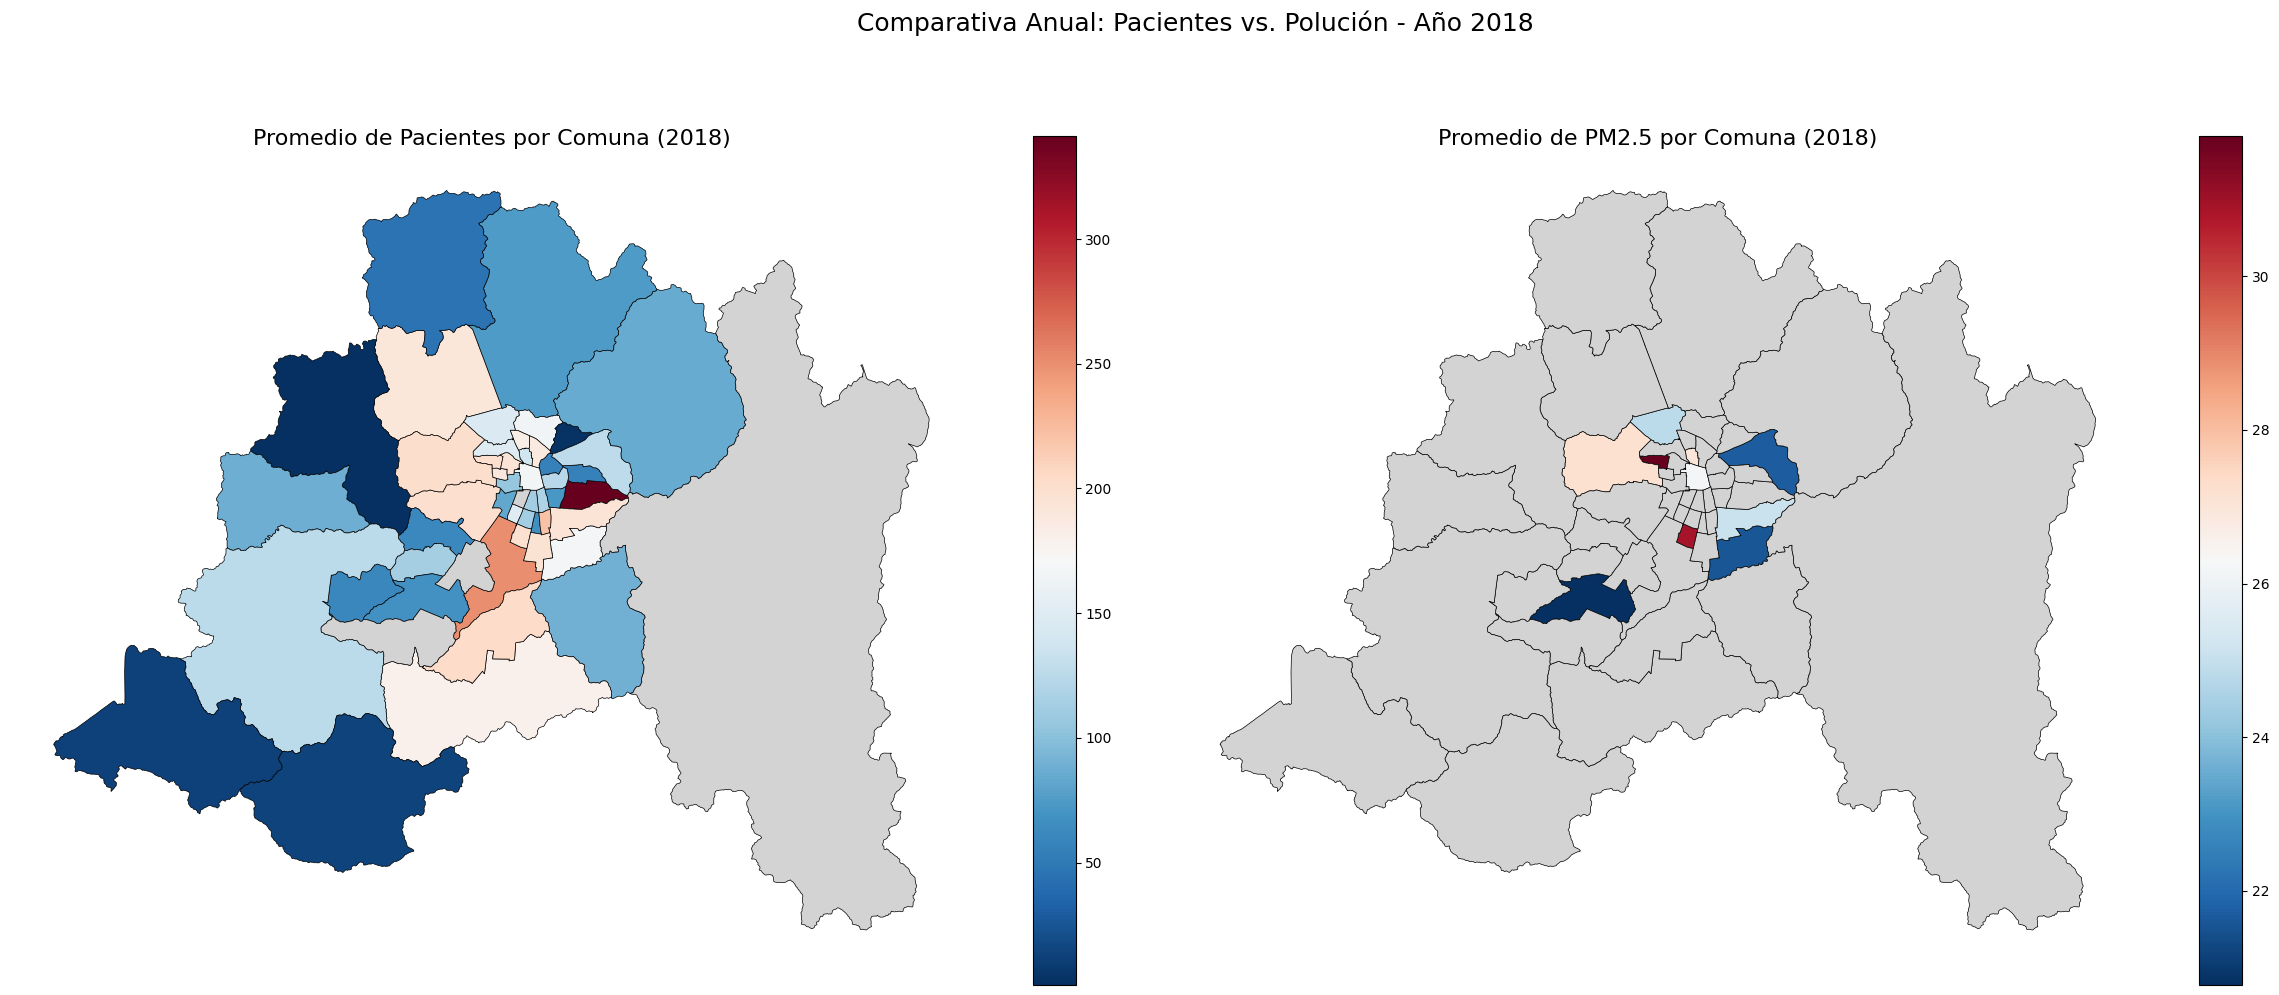

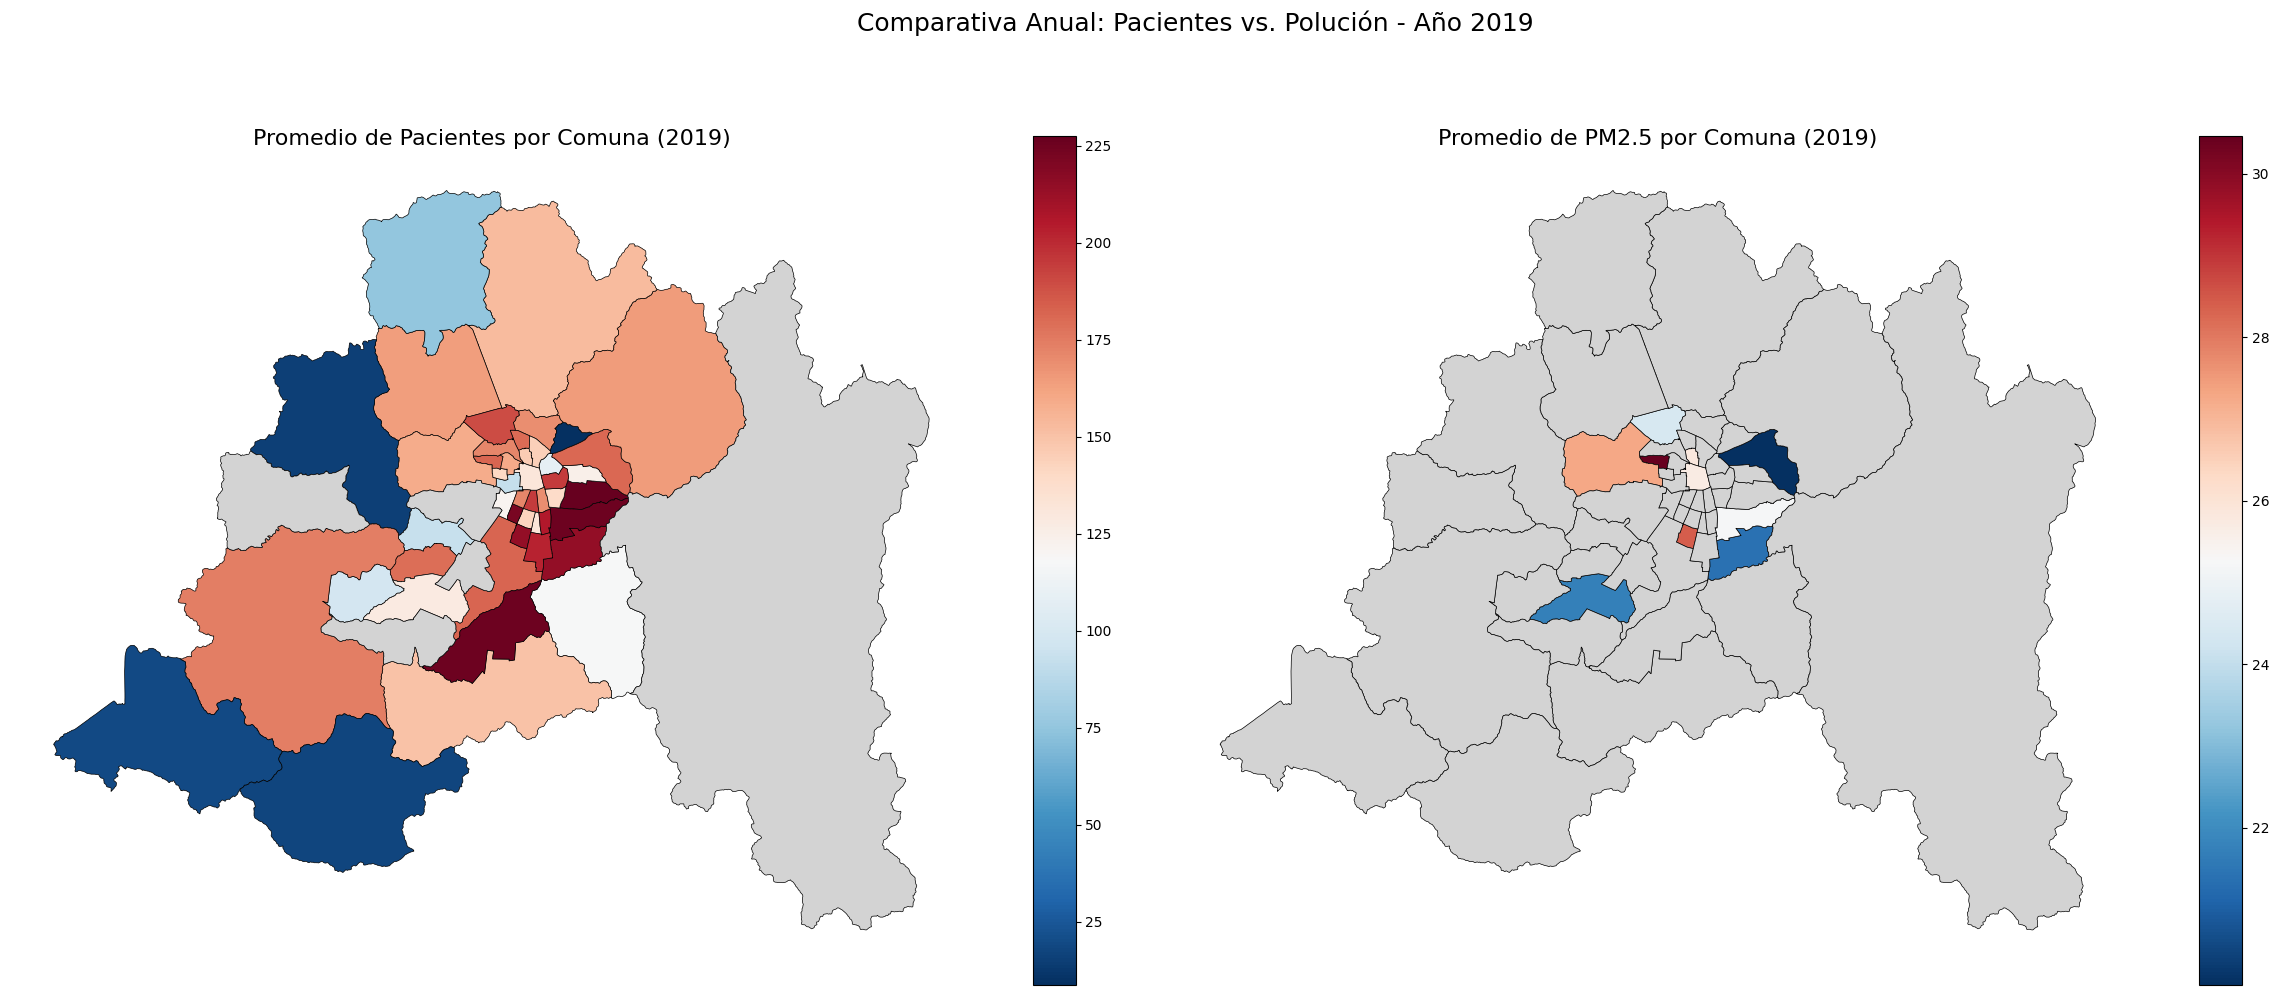

In [68]:
# renombrar columna Estacion a Comuna y AÑO a Año
df_contaminacion = df_contaminacion.rename(columns={'Estacion':'Comuna', 'AÑO': 'Año'})

plotear_anual(2017, df_REM17, df_contaminacion, comunas)
plotear_anual(2018, df_REM18, df_contaminacion, comunas)
plotear_anual(2019, df_REM19, df_contaminacion, comunas)

Ahora graficamos el promedio de paciente por comuna por año v/s indice promedio de contaminación por comuna.

In [69]:
df_REM = pd.concat([df_REM17, df_REM18, df_REM19], ignore_index=True)
# Calcular el promedio de pacientes global por cada comuna
promedio_pacientes_comuna = df_REM.groupby('Comuna')['n_pacientes'].mean().reset_index()

# Unir (Merge) los datos al GeoDataFrame usando la columna 'Comuna'
mapa_con_enfermos = comunas.merge(
    promedio_pacientes_comuna,
    on='Comuna',        # La columna que coincide en ambos DFs
    how='left'          # Mantenemos todas las comunas del mapa (left join)
)


PM25_por_comuna = df_contaminacion.groupby('Comuna')['PM25'].mean().reset_index()

# Unir (Merge) los datos al GeoDataFrame usando la columna 'Comuna'
mapa_con_PM25 = comunas.merge(
    PM25_por_comuna,
    on='Comuna',        # La columna que coincide en ambos DFs
    how='left'          # Mantenemos todas las comunas del mapa (left join)
)

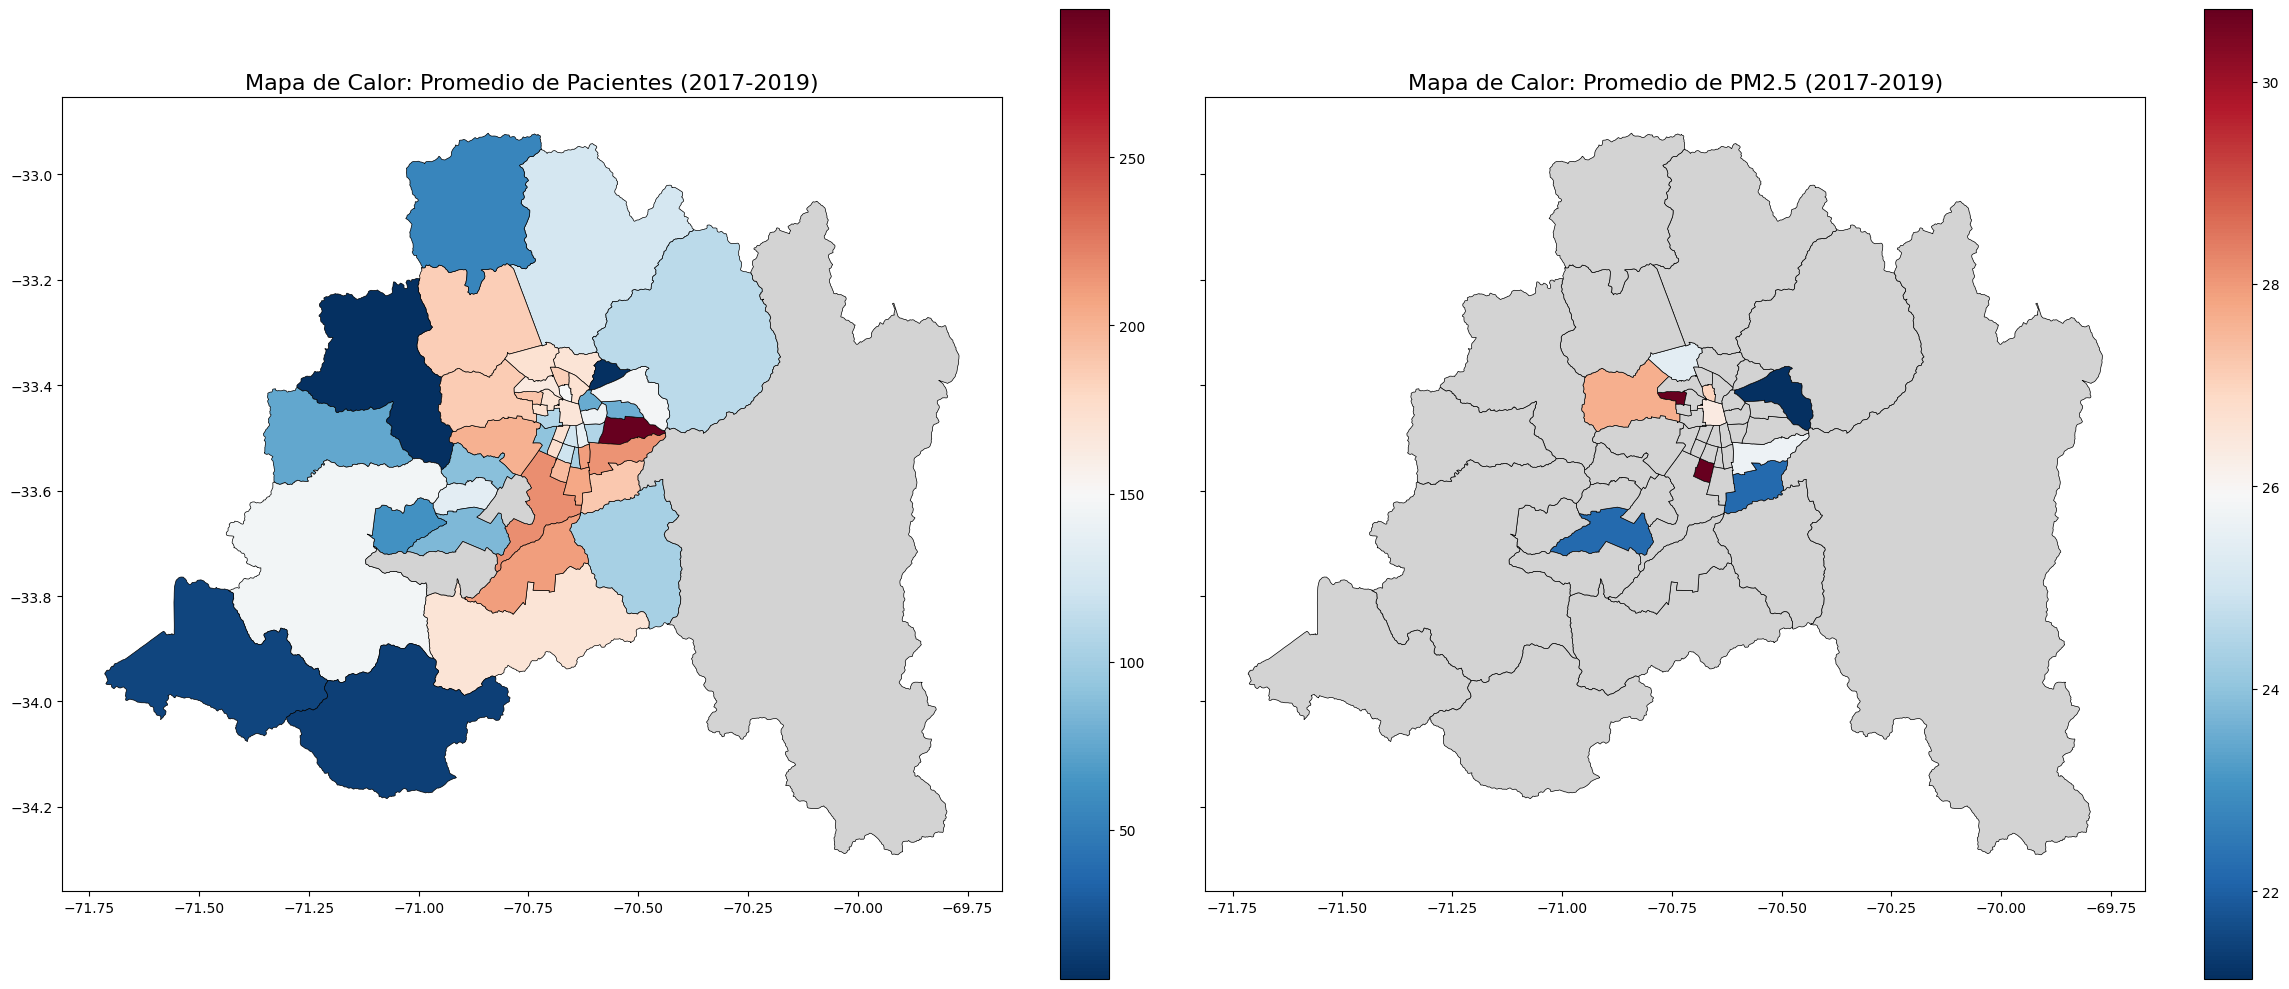

In [70]:
# sharey=True y sharex=True asegura que ambos mapas tengan la misma escala geográfica
fig, axes = plt.subplots(1, 2, figsize=(24, 10), sharex=True, sharey=True)

ax1 = axes[0] # Eje izquierdo
ax2 = axes[1] # Eje derecho

# Primer mapa: Pacientes en ax1
mapa_con_enfermos.plot(
    column='n_pacientes',
    ax=ax1,
    cmap='RdBu_r', # Colores cálidos
    legend=True,
    edgecolor='black',
    linewidth=0.5,
    missing_kwds={"color": "lightgrey", "label": "Sin Datos"}
)

ax1.set_title('Mapa de Calor: Promedio de Pacientes (2017-2019)', fontsize=16)
# ax1.set_axis_off()


# GSegundo mapa: PM2.5 en ax2
mapa_con_PM25.plot(
    column='PM25',
    ax=ax2,
    cmap='RdBu_r', # Colores cálidos
    legend=True,
    edgecolor='black',
    linewidth=0.5,
    missing_kwds={"color": "lightgrey", "label": "Sin Datos"}
)
ax2.set_title('Mapa de Calor: Promedio de PM2.5 (2017-2019)', fontsize=16)
# ax2.set_axis_off()

# Ajustar el diseño para que no se superpongan los elementos
plt.tight_layout()
plt.show()

In [71]:
# dataframe final con las columnas comuna, n_pacientes (promedio) y PM25 (promedio)
df_final = pd.merge(promedio_pacientes_comuna, PM25_por_comuna, on='Comuna', how='left')
# df_final.head()
# borrar comunas con nulos en PM25
df_final = df_final.dropna(subset=['PM25'])
# ordenar de mayor a menor n_pacientes
df_final = df_final.sort_values(by='n_pacientes', ascending=False).reset_index(drop=True)
df_final

,Comuna,n_pacientes,PM25
0,La Florida,214.754630,25.671920
1,El Bosque,196.023148,30.717268
2,Cerro Navia,191.523148,30.701520
3,Puente Alto,188.759259,22.195295
4,Pudahuel,186.703704,27.650708
5,Quilicura,171.847222,25.403205
6,Santiago,168.421296,26.349568
7,Independencia,149.384259,26.979252
8,Las Condes,146.782407,21.131355
9,Talagante,84.625000,22.185104


In [72]:
df_final.describe()

,n_pacientes,PM25
count,10.000000,10.000000
mean,169.882407,25.898519
std,36.565121,3.354212
min,84.625000,21.131355
25%,154.143519,22.997272
50%,179.275463,26.010744
75%,190.832176,27.482844
max,214.754630,30.717268


In [73]:
df_REM.head(20)

,Consulta_por,n_pacientes,Comuna,Mes,Año,Num_mes
0,IRA ALTA,465,Santiago,Enero,2017,1
1,SINDROME BRONQUIAL OBSTRUCTIVO,82,Santiago,Enero,2017,1
2,NEUMONÍA,54,Santiago,Enero,2017,1
3,ASMA,23,Santiago,Enero,2017,1
4,ENFERMEDAD PULMONAR OBSTRUCTIVA CRÓNICA,32,Santiago,Enero,2017,1
5,OTRAS RESPIRATORIAS,192,Santiago,Enero,2017,1
6,IRA ALTA,132,Cerrillos,Enero,2017,1
7,SINDROME BRONQUIAL OBSTRUCTIVO,19,Cerrillos,Enero,2017,1
8,NEUMONÍA,10,Cerrillos,Enero,2017,1
9,ASMA,5,Cerrillos,Enero,2017,1


In [74]:
# 1. Sumar los pacientes por Comuna, Año y Mes (Num_mes)
df_pacientes_mensual = df_REM.groupby(['Comuna', 'Año', 'Num_mes'])['n_pacientes'].sum().reset_index()

# 2. Recrear una columna de 'Fecha' (al primer día del mes) para facilitar cálculos.
# Esto es esencial para calcular los días del mes.
# Creamos una columna Mes_str para combinar
df_pacientes_mensual['Mes_str'] = df_pacientes_mensual['Num_mes'].astype(str).str.zfill(2)
df_pacientes_mensual['Fecha'] = pd.to_datetime(
    df_pacientes_mensual['Año'].astype(str) + '-' + df_pacientes_mensual['Mes_str'],
    format='%Y-%m'
)

# 3. Calcular el promedio de pacientes atendidos por día en el mes.
df_pacientes_mensual['dias_mes'] = df_pacientes_mensual['Fecha'].dt.daysinmonth
df_pacientes_mensual['n_pacientes_diario_prom'] = df_pacientes_mensual['n_pacientes'] / df_pacientes_mensual['dias_mes']

# 4. Seleccionar columnas clave para el merge
df_pacientes_merge = df_pacientes_mensual[['Comuna', 'Num_mes', 'Año', 'n_pacientes_diario_prom']].copy()

print("DataFrame de Pacientes Agregado y Promediado por Día (Mensual):")
print(df_pacientes_merge.head())

DataFrame de Pacientes Agregado y Promediado por Día (Mensual):
  Comuna  Num_mes   Año  n_pacientes_diario_prom
0  Alhué        1  2017                 1.129032
1  Alhué        2  2017                 1.107143
2  Alhué        3  2017                 0.935484
3  Alhué        4  2017                 3.466667
4  Alhué        5  2017                 3.645161


In [75]:
df_PM_agregado = df_contaminacion.copy()

# 1. Crear una columna de tiempo completa (Fecha y Hora)
# HORA (ej. 100) debe convertirse en un intervalo de tiempo (ej. 60 minutos)
# Convertimos la HORA (HHMM) a minutos totales
df_PM_agregado['Horas'] = df_PM_agregado['HORA'] // 100
df_PM_agregado['Minutos'] = df_PM_agregado['HORA'] % 100
df_PM_agregado['Total_Minutos'] = df_PM_agregado['Horas'] * 60 + df_PM_agregado['Minutos']

# Sumamos el tiempo (Total_Minutos) a la columna FECHA (que ya es datetime)
df_PM_agregado['Fecha_Completa'] = df_PM_agregado['FECHA'] + pd.to_timedelta(df_PM_agregado['Total_Minutos'], unit='m')

# 2. Agregación a nivel diario y por Comuna
df_PM_agregado['Fecha_Diaria'] = df_PM_agregado['Fecha_Completa'].dt.normalize()

# 3. Agrupar por Comuna y Día
# El nombre 'Comuna' ya está verificado
df_PM_agregado = df_PM_agregado.groupby(['Fecha_Diaria', 'Comuna'])['PM25'].mean().reset_index()

# 4. Renombrar columnas y preparar claves de merge
df_PM_agregado = df_PM_agregado.rename(columns={'PM25': 'PM25_promedio', 'Fecha_Diaria': 'Fecha'})

df_PM_agregado['Num_mes'] = df_PM_agregado['Fecha'].dt.month
df_PM_agregado['Año'] = df_PM_agregado['Fecha'].dt.year

print("--- DataFrame de PM2.5 Diario Listo para el Merge ---")
print(f"Filas totales (Esperado > 0): {len(df_PM_agregado)}")
print(df_PM_agregado.head())

--- DataFrame de PM2.5 Diario Listo para el Merge ---
Filas totales (Esperado > 0): 10358
       Fecha         Comuna  PM25_promedio  Num_mes   Año
0 2017-01-01    Cerro Navia        19.9167        1  2017
1 2017-01-01      El Bosque        18.0417        1  2017
2 2017-01-01  Independencia        18.8750        1  2017
3 2017-01-01     La Florida        18.1667        1  2017
4 2017-01-01       Pudahuel        18.6667        1  2017


In [76]:
# 1. Realizar el merge (Left Merge)
# Unimos el PM2.5 diario (df_PM_agregado) con el promedio de pacientes del mes (df_pacientes_merge).
df_comuna_diario = pd.merge(
    df_PM_agregado,
    df_pacientes_merge,
    on=['Comuna', 'Num_mes', 'Año'],
    how='left'
)

# 2. Limpieza final y ajustes de formato
df_comuna_diario = df_comuna_diario.drop(columns=['Num_mes', 'Año'])

# Renombrar columna de pacientes y establecer el índice de Fecha
df_comuna_diario = df_comuna_diario.rename(columns={'n_pacientes_diario_prom': 'n_pacientes'})
df_comuna_diario = df_comuna_diario.set_index('Fecha')
df_comuna_diario = df_comuna_diario.sort_index()

# 3. Eliminar las filas donde no se encontraron datos de pacientes (NaN)
df_comuna_diario = df_comuna_diario.dropna(subset=['n_pacientes', 'PM25_promedio'])

print("\n--- DataFrame Unificado (df_comuna_diario) FINAL ---")
print(f"Filas totales del DF unificado: {len(df_comuna_diario)}")
print(df_comuna_diario.head())


--- DataFrame Unificado (df_comuna_diario) FINAL ---
Filas totales del DF unificado: 10358
                   Comuna  PM25_promedio  n_pacientes
Fecha                                                
2017-01-01    Cerro Navia        19.9167    15.903226
2017-01-01      El Bosque        18.0417    25.193548
2017-01-01  Independencia        18.8750    15.516129
2017-01-01     La Florida        18.1667    28.903226
2017-01-01       Pudahuel        18.6667    41.548387


In [77]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error 

comunas_analizar = df_comuna_diario['Comuna'].unique()
df_resultados_final = pd.DataFrame()

print(f"Iniciando cálculo de regresión y MSE para {len(comunas_analizar)} comunas...")

for comuna in comunas_analizar:
    # 1. Filtrar y preparar datos
    df_comuna = df_comuna_diario[df_comuna_diario['Comuna'] == comuna].copy()
    df_comuna = df_comuna.rename(columns={'PM25_promedio': 'PM25', 'n_pacientes': 'Pacientes'})
    
    # --- A. ENCONTRAR LAG ÓPTIMO ---
    max_lag = 7
    lags = range(max_lag + 1)
    correlations = {}

    for lag in lags:
        df_comuna[f'PM25_lag_{lag}'] = df_comuna['PM25'].shift(lag)
        correlation = df_comuna['Pacientes'].corr(df_comuna[f'PM25_lag_{lag}'])
        correlations[lag] = correlation

    df_correlations = pd.Series(correlations).abs()
    lag_optimo = df_correlations.idxmax()
    
    # --- B. MODELAMIENTO DE REGRESIÓN LINEAL (USANDO EL LAG ÓPTIMO) ---
    
    X = df_comuna[[f'PM25_lag_{lag_optimo}']].dropna()
    Y = df_comuna['Pacientes'].loc[X.index] 

    if len(X) < 100:
        continue

    # 2. Entrenar el modelo
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
    modelo_regresion = LinearRegression()
    modelo_regresion.fit(X_train, Y_train)

    # 3. Obtener Métricas
    Y_pred = modelo_regresion.predict(X_test)
    
    coeficiente = modelo_regresion.coef_[0]
    r2 = r2_score(Y_test, Y_pred)
    mse = mean_squared_error(Y_test, Y_pred) # Cálculo del MSE

    # 4. Guardar los resultados en el DataFrame final
    df_temp = pd.DataFrame({
        'Comuna': [comuna],
        'Lag_Optimo': [lag_optimo],
        'Correlacion_Max': [df_correlations[lag_optimo]],
        'Coeficiente_Beta': [coeficiente],
        'R2': [r2],
        'MSE': [mse] # Nuevo campo
    })
    df_resultados_final = pd.concat([df_resultados_final, df_temp], ignore_index=True)

print("\n--- Resultados Finales de Regresión por Comuna (con MSE) ---")
print(df_resultados_final)

Iniciando cálculo de regresión y MSE para 10 comunas...

--- Resultados Finales de Regresión por Comuna (con MSE) ---
          Comuna  Lag_Optimo  Correlacion_Max  Coeficiente_Beta        R2  \
0    Cerro Navia           2         0.418617          0.292909  0.140800   
1      El Bosque           5         0.125735          0.065786  0.023918   
2  Independencia           6         0.253335          0.232406  0.029308   
3     La Florida           4         0.037770         -0.033141 -0.008395   
4       Pudahuel           3         0.373585         -0.251226  0.086453   
5    Puente Alto           0         0.282120         -0.345206  0.068848   
6      Quilicura           7         0.465839          0.346286  0.296531   
7       Santiago           0         0.067048          0.067777 -0.032080   
8      Talagante           6         0.472149          0.324242  0.271905   
9     Las Condes           2         0.121451          0.099251  0.034201   

          MSE  
0  167.714452  
1 

Calculando matriz de correlación (Pacientes vs. PM2.5 con Lag) por comuna...

--- Matriz de Correlación Final ---
                  Lag 0     Lag 1     Lag 2     Lag 3     Lag 4     Lag 5  \
Cerro Navia    0.417098  0.416578  0.418617  0.414765  0.412993  0.408905   
El Bosque      0.103534  0.109828  0.113043  0.120198  0.124200  0.125735   
Independencia  0.240434  0.241481  0.239418  0.241388  0.247388  0.253187   
La Florida    -0.037690 -0.037110 -0.032531 -0.035687 -0.037770 -0.034947   
Pudahuel      -0.369139 -0.370516 -0.369528 -0.373585 -0.371148 -0.365362   
Puente Alto   -0.282120 -0.271445 -0.262397 -0.255262 -0.248022 -0.240992   
Quilicura      0.444545  0.447022  0.453469  0.454138  0.456894  0.459437   
Santiago       0.067048  0.062526  0.057004  0.045119  0.033485  0.026003   
Talagante      0.438170  0.442405  0.446863  0.455099  0.464245  0.469822   
Las Condes     0.114956  0.117950  0.121451  0.117648  0.117097  0.112884   

                  Lag 6     Lag 7  
Ce

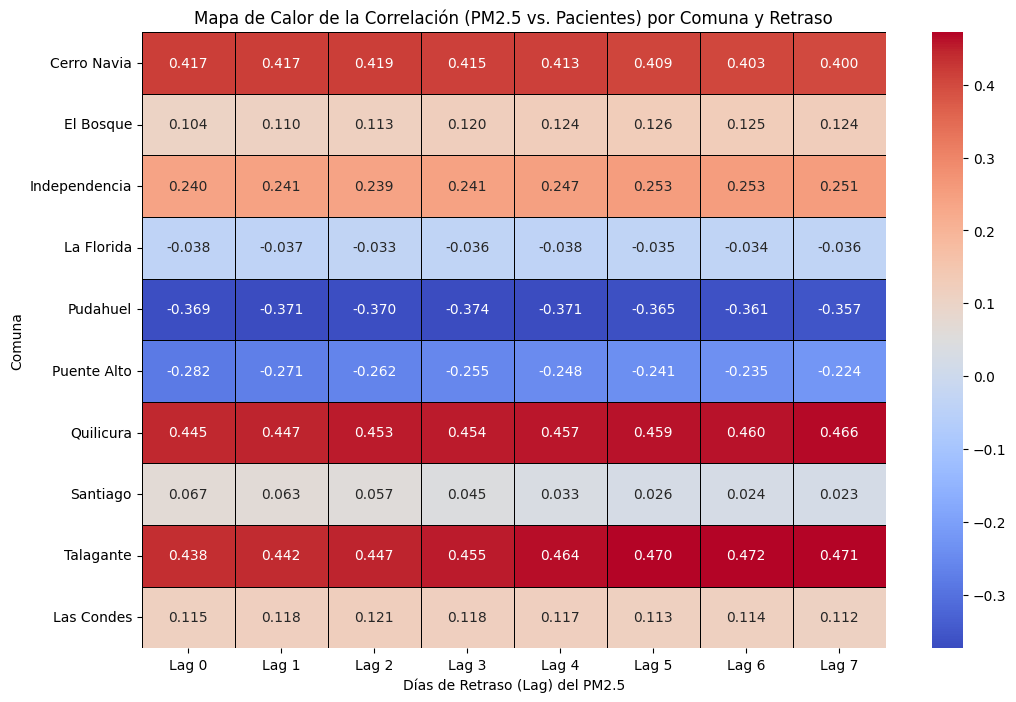

In [78]:
comunas_analizar = df_comuna_diario['Comuna'].unique()
lags = range(8) # Lags 0 a 7
correlaciones_por_comuna = {}

print("Calculando matriz de correlación (Pacientes vs. PM2.5 con Lag) por comuna...")

for comuna in comunas_analizar:
    df_comuna = df_comuna_diario[df_comuna_diario['Comuna'] == comuna].copy()
    df_comuna = df_comuna.rename(columns={'PM25_promedio': 'PM25', 'n_pacientes': 'Pacientes'})
    
    correlations = {}
    
    # Calcular correlación para cada lag (0 a 7)
    for lag in lags:
        df_comuna[f'PM25_lag_{lag}'] = df_comuna['PM25'].shift(lag)
        
        # Correlación entre Pacientes (hoy) y PM2.5 del día t-lag
        correlation = df_comuna['Pacientes'].corr(df_comuna[f'PM25_lag_{lag}'])
        correlations[lag] = correlation

    # Guardar la serie de correlaciones para esta comuna
    correlaciones_por_comuna[comuna] = pd.Series(correlations)

# 1. Crear la Matriz de Correlación Final
df_heatmap = pd.DataFrame(correlaciones_por_comuna).T
df_heatmap.columns = [f'Lag {l}' for l in lags] # Renombrar columnas para la visualización

print("\n--- Matriz de Correlación Final ---")
print(df_heatmap)

# 2. Generar el Mapa de Calor
plt.figure(figsize=(12, 8))
sns.heatmap(
    df_heatmap,
    annot=True,
    fmt=".3f",
    cmap='coolwarm', # Utiliza colores fríos para valores bajos y cálidos para valores altos
    cbar=True,
    linewidths=0.5,
    linecolor='black'
)

plt.title('Mapa de Calor de la Correlación (PM2.5 vs. Pacientes) por Comuna y Retraso')
plt.xlabel('Días de Retraso (Lag) del PM2.5')
plt.ylabel('Comuna')
plt.show()